In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def median_filter(noisy_img: cv2.Mat, kernel_size: int = 41) -> tuple[cv2.Mat, cv2.Mat] :
	"""
	Performs median filtering to separate noise from image data. This method is preferred over ones such as Gaussian blur, as this preserves edges.

	PASS GRAYSCALE IMAGE DATA ONLY.

	Example::

		import cv2

		img = cv2.imread("./printed_sample.png", cv2.IMREAD_GRAYSCALE)

		filtered_result, filtered_bg = median_filter(img)
	"""
	background = cv2.medianBlur(noisy_img, ksize=kernel_size)
	result = cv2.subtract(background, noisy_img)
	result = cv2.bitwise_not(result)
	return (result, background)

In [22]:
def show_img_inline(img: cv2.Mat, w: int = 10, h: int = 10, cmap: str ='gray') -> None:
	"""
	Utility function that takes image data in cv2.Mat or numpy.ndarray forms and shows the image using the matplotlib.pyplot API

	Example::

		import matplotlib.pyplot as plt

		img = cv2.imread("./handwritten_sample.png")
		
		show_img_inline(img)
	"""
	
	# removing details from matplotlib graph which are unnecessary for image displaying purposes
	plt.rcParams["axes.grid"] = False
	plt.rcParams["axes.spines.bottom"] = False
	plt.rcParams["axes.spines.left"] = False
	plt.rcParams["axes.spines.right"] = False
	plt.rcParams["axes.spines.top"] = False

	plt.rcParams["xtick.labelbottom"] = False
	plt.rcParams["xtick.labeltop"] = False
	plt.rcParams["ytick.labelleft"] = False
	plt.rcParams["ytick.labelright"] = False

	plt.figure(figsize=(w, h))
	plt.imshow(img, cmap=cmap)
	plt.show()

In [23]:
def pipeline(
	input: str = "./handwritten_sample.jpg",
	filter_kernel_size: int = 41,
	line_dilation_kernel_size: tuple[int, int] = (1, 110),
	min_line_height: int = 33,
	show_roi: bool = False
) -> None:
	"""
	Processing pipeline.

	Load image -> Median filtering -> Binarization/thresholding -> dilation -> contouring -> marking
	"""

	# load image in grayscale form
	img = cv2.imread(input, cv2.IMREAD_GRAYSCALE)
	print("[+] Image loaded.")
	show_img_inline(img)


	# denoising using median filtering
	# TODO: import this from denoising, don't redefine in this file
	img, _ = median_filter(img, kernel_size=filter_kernel_size)
	print("[+] Median filtering applied")
	show_img_inline(img)

	image = img.copy()

	# Otsu (statistical) binarization thresholding
	threshval, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
	print("[+] Otsu's binarizing threshold applied. Threshold value: {}".format(threshval))
	show_img_inline(thresh)


	# dilation. larger the kernel size, larger the inter-word gap tolerance to connect for recognizing line regions.
	# TODO: lines on different angles are joined together.
	# TODO: it might not be necessary to separate them for character recognition, but it generates extra contours.
	# TODO: thus, search for alternative methods to isolate line regions
	kernel = np.ones(line_dilation_kernel_size, np.uint8)
	img_line_dilation = cv2.dilate(thresh, kernel, iterations=1)
	print("[+] Dilation applied to connect word regions to form lines")
	show_img_inline(img_line_dilation)

	# find contours, retain only minimal points necessary
	ctrs, _hier = cv2.findContours(img_line_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

	# sort contours based on top-left corner position of contour
	# but give high priority to top position over left position
	# TODO: is the sort working properly? check the logic
	sorted_ctrs = sorted(ctrs, key=lambda ctr: (cv2.boundingRect(ctr)[1] + 0.1*cv2.boundingRect(ctr)[0]))

	print("[+] Contours marked around {} potential regions of interest.".format(len(ctrs)))


	roi = []
	if show_roi:
		print("[+] Regions of interest are:")
		print("[", "-"*25, "]")
		
	# for every contour
	for i, ctr in enumerate(sorted_ctrs):
		# Get bounding box
		x, y, w, h = cv2.boundingRect(ctr)

		# ignore lines of height smaller than min_line_height
		if(h < min_line_height):
			continue
		
		roi.append((x, y, w, h))

	if show_roi:
		for el in roi:
			x, y, w, h = el
			show_img_inline(image[y:y+h, x:x+w])


	print("[+] Drawing bounding boxes around {} regions of interest:".format(len(roi)))

	# for every ROI
	for el in roi:
		x, y, w, h = el

		# draw bounding box over image
		cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
	
	print("[+] Boxes drawn.")
	show_img_inline(image, w=15, h=15)

[+] Image loaded.


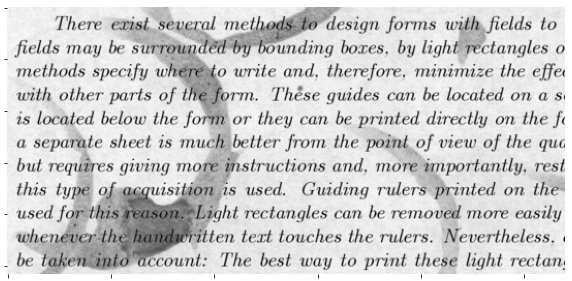

[+] Median filtering applied


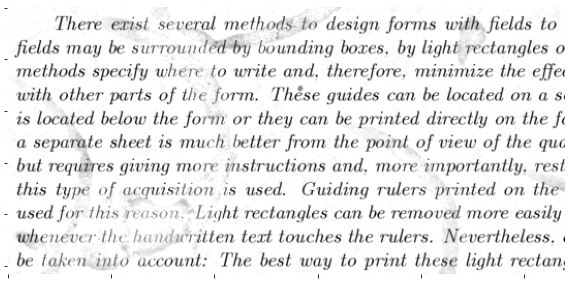

[+] Otsu's binarizing threshold applied. Threshold value: 190.0


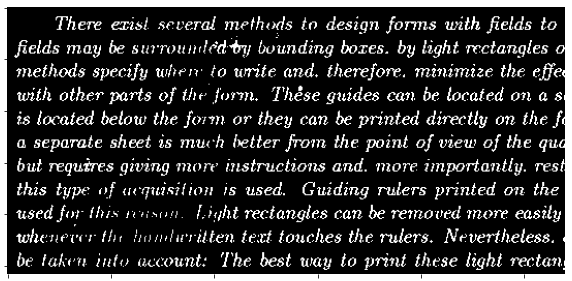

[+] Dilation applied to connect word regions to form lines


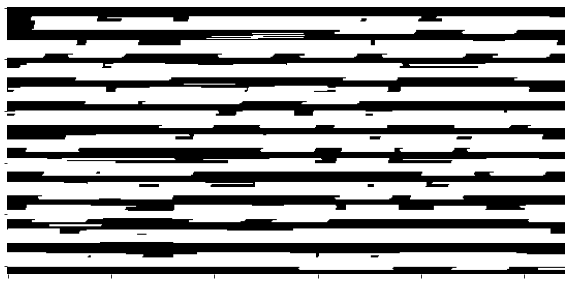

[+] Contours marked around 16 potential regions of interest.
[+] Regions of interest are:
[ ------------------------- ]


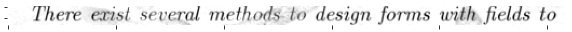

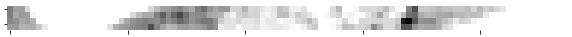

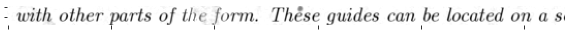

[+] Drawing bounding boxes around 12 regions of interest:
[+] Boxes drawn.


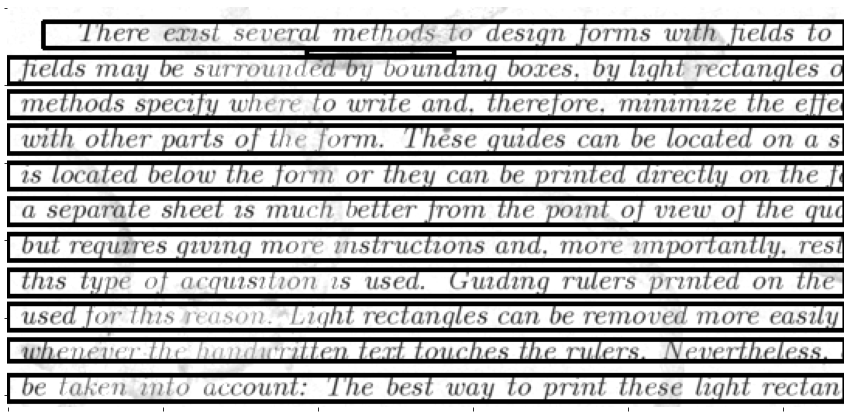

In [24]:
pipeline(
	"./printed_sample.png",
	line_dilation_kernel_size=(1, 50),
	show_roi=True, min_line_height=4)

[+] Image loaded.


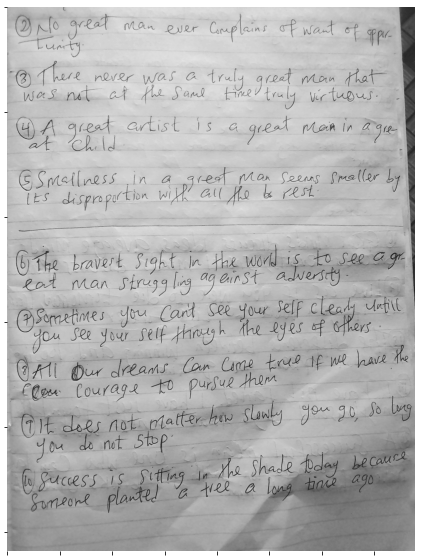

[+] Median filtering applied


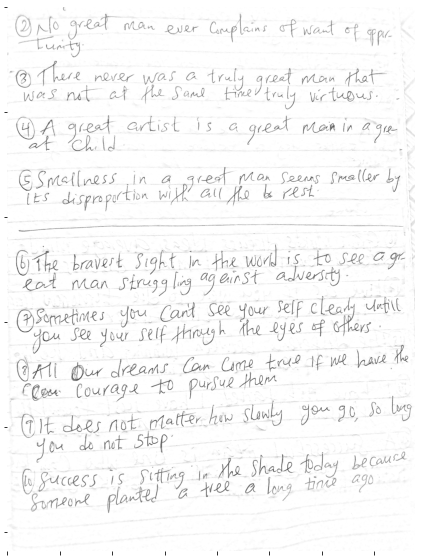

[+] Otsu's binarizing threshold applied. Threshold value: 213.0


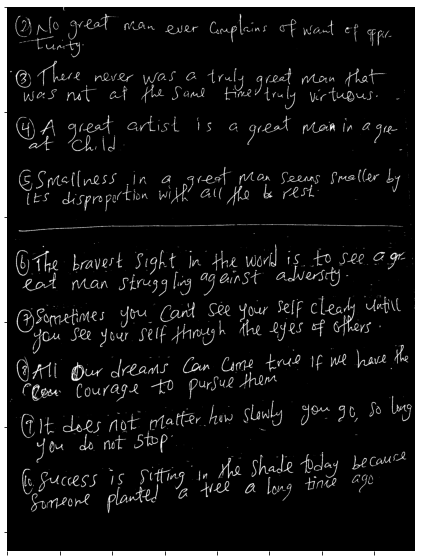

[+] Dilation applied to connect word regions to form lines


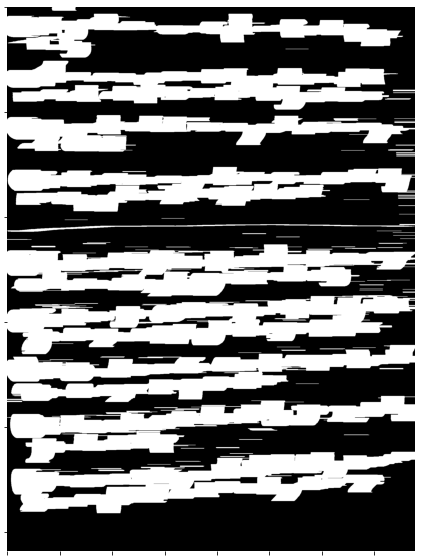

[+] Contours marked around 95 potential regions of interest.
[+] Drawing bounding boxes around 10 regions of interest:
[+] Boxes drawn.


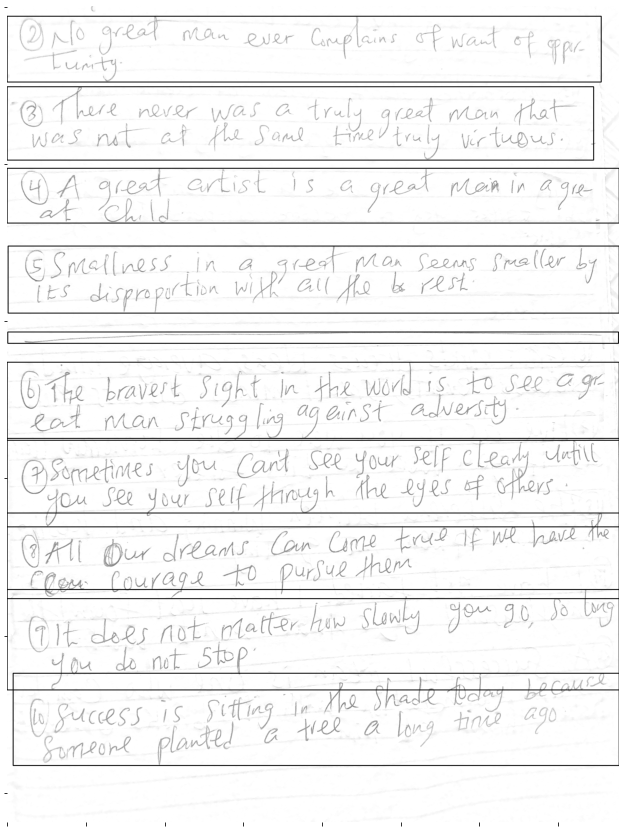

In [25]:
pipeline(
	"./handwritten_sample.jpg",
	line_dilation_kernel_size=(2, 110))